In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, meg_from_spikes
from nengo_learn_assoc_mem.utils import gen_feed_func

from collections import namedtuple

# MEG with full vocab

In [62]:
dimensions = 64
n_neurons = 500
seed = 8

rec_inhib = -3e-3
rec_synapse = 0.2
p_n = 0.1

t_present = 0.3
t_pause = 0.0
t_each = t_pause + t_present
dt = 0.001

n_items = 16

In [63]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [64]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+int(t_each/dt)*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+int(t_each/dt)*len(foil2_pair_vecs))

In [74]:
fan_and_foil = fan2 + fan1 + foil1 + foil2
ff_pairs = [f"{f1}+{f2}" for f1, f2 in fan_and_foil]

In [75]:
neuron_type = nengo.LIFRate()
c = nengo.dists.CosineSimilarity(dimensions).ppf(1 - p_n)

with nengo.Network() as model:
    stim = nengo.Node(gen_feed_func(vocab, ff_pairs, t_present))

    ens = nengo.Ensemble(n_neurons, dimensions,
                         [intercepts=c*np.ones(n_neurons)], neuron_type=neuron_type)

    nengo.Connection(stim, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons,
                     transform=rec_inhib*np.eye(n_neurons), synapse=rec_synapse)

    p_stim = nengo.Probe(stim, synapse=None)
    p_spikes = nengo.Probe(ens.neurons, synapse=None)

In [76]:
with nengo.Simulator(model) as sim:
    sim.run(len(ff_pairs)*t_present)

Building finished in 0:00:01.                                                                                
Simulating finished in 0:00:07.                                                                              


In [77]:
meg_resp = meg_from_spikes(sim.data[p_spikes])

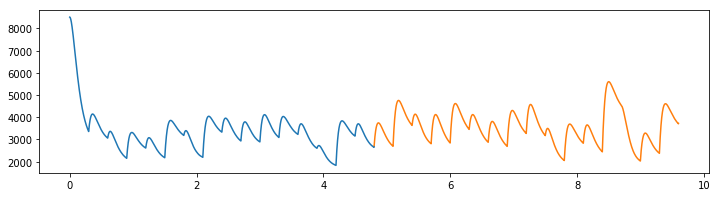

In [78]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], meg_resp[fan1_slc])
plt.plot(sim.trange()[fan2_slc], meg_resp[fan2_slc])

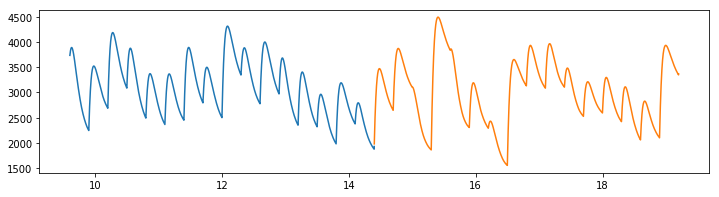

In [79]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[foil1_slc], meg_resp[foil1_slc])
plt.plot(sim.trange()[foil2_slc], meg_resp[foil2_slc])

In [80]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, fan1_slc),
                 "fan2": SlcStim(2, True, fan2_slc),
                 "foil1": SlcStim(1, False, foil1_slc),
                 "foil2": SlcStim(2, False, foil2_slc)}

In [81]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = meg_resp[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

(2000, 4000)

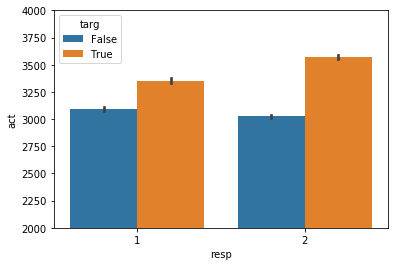

In [82]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)
ax.set_ylim(2000, 4000)

# Classification Accuracy